# 🌐 GCP + GitHub Actions Setup Guide
**Dr. Dave Wanik and Rohit Akole** - Dept. Operations and Information Management - University of Connecticut

Recreate the Cloud Functions Gen2 + Cloud Scheduler Environment

This guide rebuilds the exact permissions, service accounts, and GitHub Actions integration from Dr. Wanik’s working scrapers, extractor (regex and LLM), materializer and ML models.
Students can follow these steps to get their own version running cleanly from a fork or new GCP project.

My GCP bucket is called 'myscrapers-dww05002' and my GitHub materials are called 'myscrapers'.

# 🚀 1. Variables — Edit These First

Before running anything, open your Cloud Shell (top right in GCP console → terminal icon), then paste and modify this block:

In [ ]:
# ==========================================================
# 🧩 EDITABLE VARIABLES
# ==========================================================
PROJECT_ID="craigslist-scraper-4849"          # e.g. "craigslist-scraper-cars-v4"
REGION="us-central1"                  # or nearest region (us-east1 works too)
BUCKET_NAME="craigslist-scraper-4849-v1" # or your custom data bucket
GITHUB_REPO="https://github.com/dehiska/CraigslistWebScraper"

# Internal naming (leave unless customizing)
WIF_POOL="github-pool"
WIF_PROVIDER="gh-actions"
RUNTIME_SA_ID="cf-runtime"
DEPLOYER_SA_ID="cf-deployer"
SCHED_SA_ID="scheduler-invoker"
# ==========================================================

# --- Derived values ---
gcloud config set project "${PROJECT_ID}"
PROJECT_NUMBER="$(gcloud projects describe "${PROJECT_ID}" --format='value(projectNumber)')"
RUNTIME_SA="${RUNTIME_SA_ID}@${PROJECT_ID}.iam.gserviceaccount.com"
DEPLOYER_SA="${DEPLOYER_SA_ID}@${PROJECT_ID}.iam.gserviceaccount.com"
SCHED_SA="${SCHED_SA_ID}@${PROJECT_ID}.iam.gserviceaccount.com"
PRINCIPAL_SET="principalSet://iam.googleapis.com/projects/${PROJECT_NUMBER}/locations/global/workloadIdentityPools/${WIF_POOL}/attribute.repository/${GITHUB_REPO}"

echo "✅ Using project ${PROJECT_ID} (${PROJECT_NUMBER})"


# ⚙️ 2. Enable Required APIs

(idempotent — safe to re-run)

In [ ]:
gcloud services enable \
  cloudfunctions.googleapis.com \
  run.googleapis.com \
  cloudscheduler.googleapis.com \
  artifactregistry.googleapis.com \
  iam.googleapis.com \
  iamcredentials.googleapis.com \
  cloudbuild.googleapis.com \
  eventarc.googleapis.com \
  storage.googleapis.com \
  serviceusage.googleapis.com


A few more APIs...

In [ ]:
gcloud services enable \
  cloudresourcemanager.googleapis.com \
  pubsub.googleapis.com \
  logging.googleapis.com \
  compute.googleapis.com

# 👥 3. Create Service Accounts

(each Cloud Function will run as the runtime SA, and GitHub deploys using the deployer SA)

In [ ]:
gcloud iam service-accounts create "${RUNTIME_SA_ID}"  --display-name="Cloud Functions Runtime" || true
gcloud iam service-accounts create "${DEPLOYER_SA_ID}" --display-name="GitHub Deployer" || true
gcloud iam service-accounts create "${SCHED_SA_ID}"    --display-name="Scheduler Invoker" || true


# 🔗 4. Workload Identity Federation (WIF) Setup

This connects GitHub Actions → GCP securely (no JSON keys!).

In [ ]:
# Create pool (once per project)
gcloud iam workload-identity-pools create "${WIF_POOL}" \
  --location="global" \
  --display-name="GitHub Actions Pool" || true

# Create provider (connects this repo to GCP)
gcloud iam workload-identity-pools providers create-oidc "${WIF_PROVIDER}" \
  --workload-identity-pool="${WIF_POOL}" \
  --location="global" \
  --display-name="GitHub OIDC Provider" \
  --issuer-uri="https://token.actions.githubusercontent.com" \
  --attribute-mapping="google.subject=assertion.sub,attribute.actor=assertion.actor,attribute.repository=assertion.repository,attribute.ref=assertion.ref" \
  --attribute-condition="attribute.repository=='${GITHUB_REPO}' && attribute.ref=='refs/heads/main'" || true


Grant GitHub Actions access to impersonate your deployer service

In [ ]:
gcloud iam service-accounts add-iam-policy-binding "${DEPLOYER_SA}" \
  --role="roles/iam.workloadIdentityUser" \
  --member="${PRINCIPAL_SET}"


# 🔒 5. Project-Level Roles for the Deployer SA

In [ ]:
for ROLE in roles/cloudfunctions.developer roles/run.admin roles/cloudscheduler.admin roles/artifactregistry.writer roles/serviceusage.serviceUsageAdmin; do
  gcloud projects add-iam-policy-binding "${PROJECT_ID}" \
    --member="serviceAccount:${DEPLOYER_SA}" \
    --role="${ROLE}"
done


# 🧩 6. Service Account-to-Service Account Relationships

Allow deployer to “act as” the runtime SA (needed to deploy Functions):

In [ ]:
gcloud iam service-accounts add-iam-policy-binding "${RUNTIME_SA}" \
  --member="serviceAccount:${DEPLOYER_SA}" \
  --role="roles/iam.serviceAccountUser"


Allow the Cloud Scheduler agent to mint OIDC tokens for the runtime SA (UPDATED MEMBER TO SCHED_SA):

In [ ]:
gcloud iam service-accounts add-iam-policy-binding "${RUNTIME_SA}" \
  --member="serviceAccount:${SCHED_SA}" \
  --role="roles/iam.serviceAccountTokenCreator"


### Allow Deployer to act as default service account user

In [ ]:
gcloud iam service-accounts add-iam-policy-binding \
  projects/-/serviceAccounts/${PROJECT_NUMBER}-compute@developer.gserviceaccount.com \
  --member="serviceAccount:${DEPLOYER_SA}" \
  --role="roles/iam.serviceAccountUser"


gcloud iam service-accounts add-iam-policy-binding ${RUNTIME_SA} \
  --member="serviceAccount:${DEPLOYER_SA}" \
  --role="roles/iam.serviceAccountAdmin"

A few more permissions

In [ ]:
# 1) Allow the deployer SA to use/impersonate the runtime SA
gcloud iam service-accounts add-iam-policy-binding "${RUNTIME_SA}" --member="serviceAccount:${DEPLOYER_SA}" --role="roles/iam.serviceAccountUser" --project="${PROJECT_ID}"

# 2a) Allow Cloud Scheduler's *managed* service agent to mint tokens for the runtime SA
gcloud iam service-accounts add-iam-policy-binding "${RUNTIME_SA}" --member="serviceAccount:${SCHEDULER_AGENT}" --role="roles/iam.serviceAccountTokenCreator" --project="${PROJECT_ID}"

And a few more... had an issue with Scraper...

In [ ]:
gcloud iam service-accounts add-iam-policy-binding "cf-runtime@craigslist-scraper-4849.iam.gserviceaccount.com" --member="serviceAccount:service-768638756832@gcp-sa-cloudscheduler.iam.gserviceaccount.com" --role="roles/iam.serviceAccountTokenCreator"

### Added the Create Bucket if not exist condition

In [ ]:
if ! gcloud storage buckets describe "gs://${BUCKET_NAME}" >/dev/null 2>&1; then
  gcloud storage buckets create "gs://${BUCKET_NAME}" --project="${PROJECT_ID}" --location="${REGION}"
fi

#🪣 7. Grant Runtime SA Access to Storage Bucket

In [ ]:
gcloud storage buckets add-iam-policy-binding "gs://${BUCKET_NAME}" \
  --member="serviceAccount:${RUNTIME_SA}" \
  --role="roles/storage.objectAdmin"


# 🧱 8. Verify Everything


In [ ]:
gcloud iam service-accounts list

Verify Workload Identity Federation:

In [ ]:
gcloud iam workload-identity-pools list --location=global
gcloud iam workload-identity-pools providers list --workload-identity-pool="${WIF_POOL}" --location=global

Check IAM relationships:

In [ ]:
gcloud projects get-iam-policy "${PROJECT_ID}" | grep "${DEPLOYER_SA}" -A3
gcloud iam service-accounts get-iam-policy "${RUNTIME_SA}"

# 🧩 9. Add Variables to GitHub Repository

In GitHub → Settings → Actions → Variables, add these:

| Variable                     | Example                                                                                                   |
| ---------------------------- | --------------------------------------------------------------------------------------------------------- |
| `WORKLOAD_IDENTITY_PROVIDER` | `projects/${PROJECT_NUMBER}/locations/global/workloadIdentityPools/${WIF_POOL}/providers/${WIF_PROVIDER}` |
| `DEPLOYER_SA`                | `${DEPLOYER_SA}`                                                                                          |
| `RUNTIME_SA`                 | `${RUNTIME_SA}`                                                                                           |
| `PROJECT_ID`                 | `${PROJECT_ID}`                                                                                           |
| `REGION`                     | `${REGION}`                                                                                               |
| `BUCKET_NAME`                | `${BUCKET_NAME}`                                                                                          |


Maybe you can run this for easy copy/paste

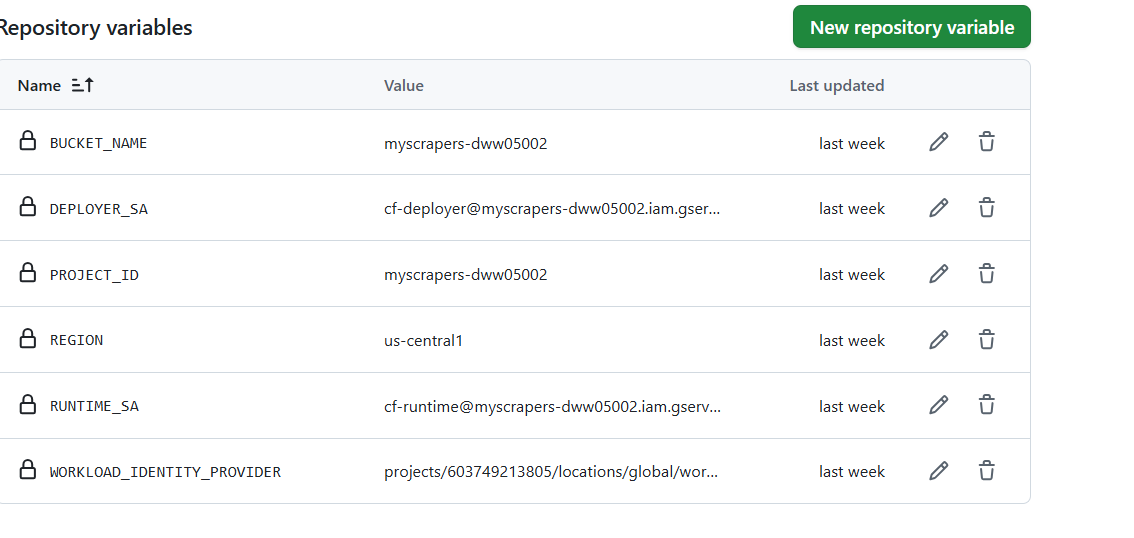

In [ ]:
# ==========================================
# ✏️ EDIT THESE VALUES
# ==========================================
PROJECT_ID="craigslist-scraper-4849"
REGION="us-central1"
BUCKET_NAME="craigslist-scraper-4849-v1"
GITHUB_REPO="https://github.com/dehiska/CraigslistWebScraper"

# Naming (leave these unless you want different names)
WIF_POOL="github-pool"
WIF_PROVIDER="gh-actions"
RUNTIME_SA_ID="cf-runtime"
DEPLOYER_SA_ID="cf-deployer"

# Optional: defaults used by your workflows (students can keep these)
EXTRACTOR_FUNCTION_NAME="extractor-per-listing"
MATERIALIZE_BODY='{}'
EXTRACTOR_BODY='{"overwrite":true,"max_files":0}'
TRAIN_DT_BODY='{"dry_run": true}'
# ==========================================

set -euo pipefail
gcloud config set project "${PROJECT_ID}" >/dev/null

PROJECT_NUMBER="$(gcloud projects describe "${PROJECT_ID}" --format='value(projectNumber)')"
RUNTIME_SA="${RUNTIME_SA_ID}@${PROJECT_ID}.iam.gserviceaccount.com"
DEPLOYER_SA="${DEPLOYER_SA_ID}@${PROJECT_ID}.iam.gserviceaccount.com"
WORKLOAD_IDENTITY_PROVIDER="projects/${PROJECT_NUMBER}/locations/global/workloadIdentityPools/${WIF_POOL}/providers/${WIF_PROVIDER}"

OUT="github_actions_variables_${PROJECT_ID}.txt"

# Pretty output + save to file
{
  echo "=================================================="
  echo "🔧 GitHub Actions → Settings → Actions → Variables"
  echo "Project: ${PROJECT_ID}  (Project # ${PROJECT_NUMBER})"
  echo "=================================================="
  printf "%-30s %s\n" "WORKLOAD_IDENTITY_PROVIDER" "${WORKLOAD_IDENTITY_PROVIDER}"
  printf "%-30s %s\n" "DEPLOYER_SA"                 "${DEPLOYER_SA}"
  printf "%-30s %s\n" "RUNTIME_SA"                  "${RUNTIME_SA}"
  printf "%-30s %s\n" "SCHED_SA"                    "${SCHED_SA}"
  printf "%-30s %s\n" "PROJECT_ID"                  "${PROJECT_ID}"
  printf "%-30s %s\n" "REGION"                      "${REGION}"
  printf "%-30s %s\n" "BUCKET_NAME"                 "${BUCKET_NAME}"
  printf "%-30s %s\n" "EXTRACTOR_FUNCTION_NAME"     "${EXTRACTOR_FUNCTION_NAME}"
  printf "%-30s %s\n" "MATERIALIZE_BODY"            "${MATERIALIZE_BODY}"
  printf "%-30s %s\n" "EXTRACTOR_BODY"              "${EXTRACTOR_BODY}"
  printf "%-30s %s\n" "TRAIN_DT_BODY"               "${TRAIN_DT_BODY}"
  echo
  echo "👉 Copy/paste these exactly as Variable values in GitHub."
  echo
  echo "----- .env style (for reference / copy to notes) -----"
  echo "WORKLOAD_IDENTITY_PROVIDER=${WORKLOAD_IDENTITY_PROVIDER}"
  echo "DEPLOYER_SA=${DEPLOYER_SA}"
  echo "RUNTIME_SA=${RUNTIME_SA}"
  echo "SCHED_SA=${SCHED_SA}"
  echo "PROJECT_ID=${PROJECT_ID}"
  echo "REGION=${REGION}"
  echo "BUCKET_NAME=${BUCKET_NAME}"
  echo "EXTRACTOR_FUNCTION_NAME=${EXTRACTOR_FUNCTION_NAME}"
  echo "MATERIALIZE_BODY=${MATERIALIZE_BODY}"
  echo "EXTRACTOR_BODY=${EXTRACTOR_BODY}"
  echo "TRAIN_DT_BODY=${TRAIN_DT_BODY}"
} | tee "${OUT}"

echo "✅ Wrote a copy to: ${OUT}"
echo "   (Cloud Shell: ⋮ → Download file → ${OUT})"


SyntaxError: invalid syntax (ipython-input-860438270.py, line 22)

# ✅ 10. Test Your Setup

Push to the main branch with one of the working YAMLs, e.g.:

* .github/workflows/deploy-extractor.yml

* .github/workflows/deploy-materialize-master.yml

* .github/workflows/deploy-train-dt.yml

Then confirm the deployment in Cloud Console:

In [ ]:
gcloud functions list --regions="${REGION}"
gcloud scheduler jobs list --location="${REGION}"


You should see all your scheduled functions enabled:

In [ ]:
extractor-per-listing-hourly
materialize-master-hourly
train-dt-hourly
craigslist-scraper-hourly


# Summary Design

In [ ]:
GitHub (OIDC) ───▶ cf-deployer (Workload Identity User)
                          │
                          ├─ deploys CF Gen2 + Scheduler
                          │
                          ▼
                    cf-runtime (ServiceAccountUser)
                          │
                          ├─ executes function logic
                          ├─ writes to GCS bucket
                          └─ trusted by Scheduler agent (TokenCreator)


# 🤖11. Vertex Permissions (PoC) - do this too!

In [ ]:
# Variables from your configuration
PROJECT_ID="craigslist-scraper-4849"
RUNTIME_SA_ID="cf-runtime"

# Construct the full Service Account email
RUNTIME_SA="${RUNTIME_SA_ID}@${PROJECT_ID}.iam.gserviceaccount.com"

echo "Project: ${PROJECT_ID}"
echo "Service Account to update: ${RUNTIME_SA}"

# Grant the Vertex AI User role to the runtime Service Account
gcloud projects add-iam-policy-binding "${PROJECT_ID}" \
    --member="serviceAccount:${RUNTIME_SA}" \
    --role="roles/aiplatform.user"

BUCKET_NAME="craigslist-scraper-4849-v1"

# Grant the Storage Object Creator role on the bucket
gcloud storage buckets add-iam-policy-binding gs://"${BUCKET_NAME}" \
    --member="serviceAccount:${RUNTIME_SA}" \
    --role="roles/storage.objectCreator"

In [ ]:
gcloud run services update extractor-llm-poc \
    --region=us-central1 \
    --timeout="3600s" # 60 minutes max

# One more...
So that we can sync our GCS data back to GitHub for review...

In [ ]:
gcloud storage buckets add-iam-policy-binding gs://craigslist-scraper-4849-v1 \
    --member='serviceAccount:cf-deployer@craigslist-scraper-4849.iam.gserviceaccount.com' \
    --role='roles/storage.objectViewer'